<a href="https://colab.research.google.com/github/wilfierd/ATI-tut/blob/main/Tut8/Word_Level_Text_Generation_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

One of the fundamental tasks in NLP is Word level text generation, which is to predict the next few words that people most likely anticipate as they type along.

The following diagram illustrates what we are trying to address. What could be the next word? We will build a neural model to predict it.



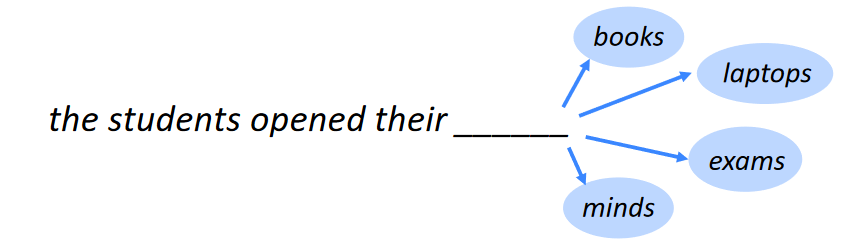

We can use RNNs for word-level text generation tasks. However, this task requires a longer memory of which words are important. Therefore, in this tutorial, we will build this language model using the LSTM architecture.

**LSTM (Long Short-Term Memory) networks** are a special type of RNN with gates that control what information to remember, forget, or pass along. This allows LSTMs to better handle long-term dependencies in sequences, making them ideal for text generation where context from earlier words matters.

We will proceed as follows:

1. Create a text corpus
2. Prepare training data
3. Specify, compile, and fit the LSTM model
4. Test the model



# Text corpus

First, we will prepare a text corpus. This includes developing a vocabulary and creating a dictionary for mapping words to integers and vice versa. In this tutorial, we will use the text corpus from "Truyện Kiều."

The text corpus can be downloaded from the following link:

[https://drive.google.com/file/d/1fpVcAHsXnj7XAE17frTBqwdpm6CWZjrm/view?usp=sharing](https://drive.google.com/file/d/1fpVcAHsXnj7XAE17frTBqwdpm6CWZjrm/view?usp=sharing)

Firstly we will load the text corpus into a Pandax Dataframe:

In [1]:
import numpy as np
import pandas as pd

## Import Required Libraries

We'll start by importing the essential libraries:
- **NumPy**: For numerical operations and array manipulation
- **Pandas**: For loading and processing the text corpus from CSV files

In [2]:
data = pd.read_csv("truyenkieu.txt",sep="/", names=["row"])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3258 entries, 0 to 3257
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   row     3258 non-null   object
dtypes: object(1)
memory usage: 25.6+ KB


,row
0,"1..Trăm năm trong cõi người ta,"
1,2..Chữ tài chữ mệnh khéo là ghét nhau.
2,"3..Trải qua một cuộc bể dâu,"
3,4..Những điều trông thấy mà đau đớn lòng.
4,"5.. Lạ gì bỉ sắc tư phong,"


### Loading the Text Corpus

We load the "Truyện Kiều" text into a Pandas DataFrame:
- Using `/` as separator since the file has a specific format
- Naming the column "row" for easy reference
- `.info()` and `.head()` help us understand the data structure and preview the content

We will perform simple text processing for the sentence in each row:

* Remove numbers at the begining of the sentence
* Remove period, comma, question mark at the end of sentence
* Delete all periods, commas, semicolon, exclamation points, ... in the sentence

In [3]:
import regex as re

def row_transform(row):
    # Delete numbers at the beginning of the sentence
    row = re.sub(r"^[0-9\.]+", "", row)

    # Remove period, comma, question mark at the end of sentence
    row = re.sub(r"[\.,\?]+$", "", row)

    # Delete all periods, commas, semicolons, exclamation points, ... in the sentence
    row = row.replace(",", " ").replace(".", " ").replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ").replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ")

    row = row.strip()
    return row

### Text Preprocessing Function

**Why preprocess text?**
Text data contains noise (punctuation, numbers, extra spaces) that can confuse the model. Clean text helps the model focus on learning word relationships rather than memorizing formatting.

**What this function does:**
1. Removes leading numbers (line numbers from the original text)
2. Removes trailing punctuation (., ?, ,)
3. Removes all punctuation within sentences
4. Strips extra whitespace

This creates clean, uniform text that's easier for the LSTM to learn from.

In [4]:
data['row'] = data.row.apply(row_transform)
textCorpus = data.row.tolist()
print(f'Length of the corpus: {len(textCorpus)}')
print(textCorpus[:5])

Length of the corpus: 3258
['Trăm năm trong cõi người ta', 'Chữ tài chữ mệnh khéo là ghét nhau', 'Trải qua một cuộc bể dâu', 'Những điều trông thấy mà đau đớn lòng', 'Lạ gì bỉ sắc tư phong']


### Apply Preprocessing

We apply the cleaning function to all rows and convert to a list:
- `apply()` processes each sentence through our transformation
- `tolist()` converts DataFrame to Python list for easier manipulation
- The result is our clean text corpus ready for tokenization

Now we create a vocabulary using the TensorFlow `Tokenizer`.

The `Tokenizer` converts text to numbers by:
- **Splitting** sentences into words
- **Building a vocabulary** that maps each unique word to a unique integer
- **Converting** between words and integers

**Why tokenization?** Neural networks work with numbers, not text. Each word gets assigned an index (e.g., "một"→1, "đã"→2). This allows the model to process and learn from the text data.

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(textCorpus)
total_words = len(tokenizer.word_index) + 1
print(f'Total words in the corpus: {total_words}')
print(tokenizer.index_word)


Total words in the corpus: 2394
{1: 'một', 2: 'đã', 3: 'người', 4: 'nàng', 5: 'lòng', 6: 'lời', 7: 'cho', 8: 'là', 9: 'cũng', 10: 'có', 11: 'rằng', 12: 'ra', 13: 'lại', 14: 'hoa', 15: 'tình', 16: 'mới', 17: 'còn', 18: 'đâu', 19: 'ai', 20: 'chẳng', 21: 'mà', 22: 'thì', 23: 'mình', 24: 'biết', 25: 'này', 26: 'trong', 27: 'đến', 28: 'đường', 29: 'nhà', 30: 'càng', 31: 'nào', 32: 'trời', 33: 'ngày', 34: 'thân', 35: 'như', 36: 'khi', 37: 'vào', 38: 'mặt', 39: 'sao', 40: 'vàng', 41: 'duyên', 42: 'xa', 43: 'về', 44: 'tay', 45: 'sinh', 46: 'làm', 47: 'chàng', 48: 'thôi', 49: 'thấy', 50: 'trước', 51: 'chi', 52: 'nghe', 53: 'những', 54: 'sau', 55: 'hai', 56: 'nỗi', 57: 'từ', 58: 'nước', 59: 'hương', 60: 'nói', 61: 'trông', 62: 'xuân', 63: 'hồng', 64: 'phải', 65: 'ta', 66: 'con', 67: 'thương', 68: 'gió', 69: 'đây', 70: 'thế', 71: 'tiếng', 72: 'chưa', 73: 'mấy', 74: 'tơ', 75: 'ở', 76: 'năm', 77: 'với', 78: 'nghĩ', 79: 'chút', 80: 'gì', 81: 'xưa', 82: 'nhau', 83: 'đi', 84: 'bên', 85: 'giờ', 86: 'mâ

# Prepare training data

## Convert a sentence into a sequence of numbers

With the vocabulary, a sentence can be converted into a sequence of numbers (the index of each word in the sentence), as the following:

In [6]:
firstSentence = textCorpus[0]
sequence = tokenizer.texts_to_sequences([firstSentence])[0]
print(firstSentence)
print(sequence)

Trăm năm trong cõi người ta
[140, 76, 26, 497, 3, 65]


### Example: Text to Sequence Conversion

Here we see how a sentence becomes a sequence of numbers:
- Each word gets mapped to its unique integer index from the vocabulary
- For example: "Trăm" → 1, "năm" → 2, etc.
- This numerical representation is what the LSTM model will process

## Create n-gram sequences

N-gram of texts are extensively used in text mining and natural language processing tasks.

An n-gram is a sequence of n words: a 2-gram (which we'll call
bigram) is a two-word sequence of words like: "Trăm năm", or "năm trong", and a 3-gram (a trigram) is a three-word sequence of words like: "Trăm năm trong" or "năm trong cõi".

**Why n-grams matter:** When generating text, the model predicts the next word based on previous words. N-grams teach the model different context lengths - 2-grams ("Trăm năm") help learn immediate word pairs, while longer n-grams help learn more complex phrases.

To create the training data, from each sentence in our corpus, we will create 2-gram, 3-gram, ... sequences from left to right. For example:

In [7]:
# Create n-gram sequences for the first sentence
for i in range(1, len(sequence)):
    n_gram_sequence = sequence[:i+1]
    print(n_gram_sequence)

[140, 76]
[140, 76, 26]
[140, 76, 26, 497]
[140, 76, 26, 497, 3]
[140, 76, 26, 497, 3, 65]


## Create input sequences

Now, we will create a set of all n-gram sequences of all sentences in the corpus:

In [8]:
# Create a set of all n-gram sequences
sequences = []
for sentence in textCorpus:
    sequence = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(sequence)):
        n_gram_sequence = sequence[:i+1]
        sequences.append(n_gram_sequence)
print(f'The number of sequences: {len(sequences)}')
print(sequences[:20])

# Print out the first tenth n-gram text
for i in range(10):
    print(tokenizer.sequences_to_texts([sequences[i]]))

The number of sequences: 19549
[[140, 76], [140, 76, 26], [140, 76, 26, 497], [140, 76, 26, 497, 3], [140, 76, 26, 497, 3, 65], [126, 118], [126, 118, 126], [126, 118, 126, 374], [126, 118, 126, 374, 351], [126, 118, 126, 374, 351, 8], [126, 118, 126, 374, 351, 8, 1173], [126, 118, 126, 374, 351, 8, 1173, 82], [1174, 194], [1174, 194, 1], [1174, 194, 1, 673], [1174, 194, 1, 673, 184], [1174, 194, 1, 673, 184, 604], [53, 94], [53, 94, 61], [53, 94, 61, 49]]
['trăm năm']
['trăm năm trong']
['trăm năm trong cõi']
['trăm năm trong cõi người']
['trăm năm trong cõi người ta']
['chữ tài']
['chữ tài chữ']
['chữ tài chữ mệnh']
['chữ tài chữ mệnh khéo']
['chữ tài chữ mệnh khéo là']


### Generate All N-gram Sequences

**Process:**
1. Convert each sentence to a sequence of word indices
2. Create all possible n-grams (2-gram, 3-gram, ..., up to full sentence)
3. Store all sequences in a list

**Result:** We have ~19,549 training examples, each showing the model a partial sentence and teaching it what word comes next. This comprehensive dataset helps the model learn word patterns across different context lengths.

## Create training data

We have `19,549` sequences in our training data. However, the lengths of the sequences are not equal.

**Why padding?** Neural networks require all inputs in a batch to have the same shape. Since our sequences have different lengths, we pad them with zeros at the beginning. This makes batch processing efficient during training - all sequences become uniform length.

In [9]:
# Pad sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))
print(sequences.shape)
for i in range(5):
    print(sequences[i])

(19549, 14)
[  0   0   0   0   0   0   0   0   0   0   0   0 140  76]
[  0   0   0   0   0   0   0   0   0   0   0 140  76  26]
[  0   0   0   0   0   0   0   0   0   0 140  76  26 497]
[  0   0   0   0   0   0   0   0   0 140  76  26 497   3]
[  0   0   0   0   0   0   0   0 140  76  26 497   3  65]


We consider the last element of each sequence to be a label. This means that our model will predict the label (the index of the last word in the sentence) based on the first thirteen elements.

**One-hot encoding:** We convert word indices to one-hot vectors (e.g., word index 5 becomes [0,0,0,0,0,1,0,...,0]). This is needed because we're doing **multi-class classification** - predicting which word from the vocabulary (2394 possible words) comes next.

Now we can create the input features and output labels for our training data:

In [10]:
X, Y = sequences[:, :-1], sequences[:, -1]
for i in range(5):
  print(X[i], '-->', Y[i])

# Convert target data to one-hot encoding
from tensorflow.keras.utils import to_categorical

Y = to_categorical(Y, num_classes = total_words)

print(X.shape)
print(Y.shape)

[  0   0   0   0   0   0   0   0   0   0   0   0 140] --> 76
[  0   0   0   0   0   0   0   0   0   0   0 140  76] --> 26
[  0   0   0   0   0   0   0   0   0   0 140  76  26] --> 497
[  0   0   0   0   0   0   0   0   0 140  76  26 497] --> 3
[  0   0   0   0   0   0   0   0 140  76  26 497   3] --> 65
(19549, 13)
(19549, 2394)


### Create Training Data (X and Y)

**Splitting features and labels:**
- `X`: All words except the last one (input context)
- `Y`: The last word (what we want to predict)

**One-hot encoding Y:**
- Converts word indices to binary vectors
- Example: Word index 5 becomes [0,0,0,0,0,1,0,...,0]
- Necessary for multi-class classification (choosing from 2394 possible words)

**Final shapes:**
- X: (19549, 13) - 19549 sequences, each up to 13 words long
- Y: (19549, 2394) - 19549 labels, each a one-hot vector of vocabulary size

# Specify and train a LSTM model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

def create_LSTM(vocab_size):
  model = Sequential()
  model.add(Embedding(input_dim = vocab_size, output_dim = 256))
  model.add(LSTM(units = 256))
  model.add(Dense(units = vocab_size, activation = 'softmax'))
  return model

### LSTM Model Architecture

**Layer breakdown:**
1. **Embedding Layer**: Converts word indices to dense 256-dimensional vectors
   - Maps each word to a learned representation that captures semantic meaning
   - Reduces dimensionality and helps the model understand word relationships

2. **LSTM Layer (256 units)**: The core sequential processor
   - Maintains long-term memory through gates (input, forget, output)
   - Learns which words are important for predicting the next word
   - Better than SimpleRNN at remembering long-range dependencies

3. **Dense Output Layer**: Produces probability distribution over vocabulary
   - `softmax` activation: Converts outputs to probabilities (sum = 1)
   - Each output represents the probability of each word being next

**Why LSTM for text generation?**
- Handles variable-length sequences
- Remembers important context from earlier in the sentence
- Can learn complex patterns like grammar and word associations

In [12]:
# Specify, compile and train the model
model = create_LSTM(total_words)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, Y, epochs=100, verbose=1)

Epoch 1/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.0110 - loss: 7.1691
Epoch 2/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0257 - loss: 6.4948
Epoch 3/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.0408 - loss: 6.0309
Epoch 4/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0693 - loss: 5.5138
Epoch 5/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.1310 - loss: 4.8639
Epoch 6/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2121 - loss: 4.2090
Epoch 7/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3145 - loss: 3.5328
Epoch 8/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4365 - loss: 2.9113
Epoch 9/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5393 - loss: 2.4037
Epoch 10/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6280 - loss: 1.9541
Epoch 11/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6960 - loss: 1.5939
Epoch 12/100
611/611 ━━━━━━━━━━━━━━━━━━━━

### Model Training Configuration

**Compilation settings:**
- `loss='categorical_crossentropy'`: Standard loss for multi-class classification
  - Measures how different predictions are from actual next words
- `optimizer='adam'`: Adaptive learning rate optimizer
  - Efficiently updates model weights during training
- `metrics=['accuracy']`: Tracks how often model predicts the correct next word

**Training:**
- `epochs=100`: Model sees all training data 100 times
- Higher epochs help model learn better patterns but risk overfitting
- Monitor accuracy - it should increase as training progresses

⚠️ **Note:** Training 100 epochs may take considerable time depending on your hardware!

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 13, 256)        │       612,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2394)           │       615,258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,260,304 (20.07 MB)

 Trainable params: 1,753,434 (6.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,506,870 (13.38 MB)

In [14]:
model.save('lstm_word_generation_v1.keras')

### Save the Trained Model

Saving the model allows us to:
- Use it later without retraining (saves hours!)
- Share the trained model with others
- Deploy it in applications

The `.keras` format is TensorFlow's modern model format.

# Test the model

A pre-trained model can be downloaded from the following link:

[https://drive.google.com/file/d/1T6jYBTB6HGke4dyPQhGqoeIlSD_LKUBK/view?usp=sharing](https://drive.google.com/file/d/1T6jYBTB6HGke4dyPQhGqoeIlSD_LKUBK/view?usp=sharing)

In [15]:
# Load the pre-trained model

from tensorflow.keras.models import load_model

model = load_model('lstm_word_generation_v1.keras')

### Load Pre-trained Model

Instead of training from scratch (which takes a long time), we can load a pre-trained model. This is especially useful for:
- Testing and experimentation
- When you don't have time/resources to train
- Demonstrations and tutorials

In [16]:
# Generate next word predictions
current_text = "phận mình"
next_words = 6

for i in range(next_words):
    sequence = tokenizer.texts_to_sequences([current_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_sequence_len-1, padding='pre')
    predicted_probs = model.predict(sequence)
    predicted_word = tokenizer.index_word[np.argmax(predicted_probs)]
    current_text += " " + predicted_word
    print(current_text)

print("Next predicted words:", current_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
phận mình thì
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
phận mình thì cũng
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
phận mình thì cũng có
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
phận mình thì cũng có nhà
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
phận mình thì cũng có nhà cũng
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
phận mình thì cũng có nhà cũng không
Next predicted words: phận mình thì cũng có nhà cũng không


### Text Generation Process

**How it works (iteratively):**
1. Start with seed text: "phận mình"
2. Convert current text to sequence of word indices
3. Pad sequence to match training data length
4. Model predicts probability distribution over all vocabulary words
5. Select word with highest probability (argmax)
6. Append predicted word to current text
7. Repeat steps 2-6 for desired number of words

**Why this approach?**
- Generates text word-by-word like humans write
- Each prediction builds on previous context
- Creates coherent, contextually-appropriate text

The model continues the phrase in the style of "Truyện Kiều"!